In [13]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.light_sources import light_source, create_TMSV_OP_Dense
from trajectree.fock_optics.devices import ry, rx, rz
from trajectree.fock_optics.measurement import create_threshold_POVM_OP_Dense, rotate_and_measure, create_PNR_POVM_OP_Dense
from trajectree.fock_optics.outputs import print_quantum_state, read_quantum_state
from trajectree.fock_optics.noise_models import single_mode_bosonic_noise_channels, depolarizing_operators, two_qubit_depolarizing_channel

from trajectree.trajectory import trajectory_evaluator, quantum_channel

import numpy as np
from scipy import sparse as sp
import qutip as qt
from numpy import sqrt
import time
import copy
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec #type: ignore
from quimb.tensor import MatrixProductOperator as mpo #type: ignore

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from functools import lru_cache
from IPython.display import HTML

This function simply creates a perfect bell state on photons. 

In [14]:
def create_perfect_bell_state(N=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=N)
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) + np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    return psi

Unlike the CHSH inequality, we calculate the CGLMP inequality directly simply by finding the expectation value of the Bell operator for the CGLMP experiment. We construct a generalized CGLMP operator from the paper: "[Maximal non-classicality in multi-setting Bell inequalities](https://iopscience.iop.org/article/10.1088/1751-8113/49/14/145301)". 

In [15]:
@lru_cache
def Alice_states(a, x, d, N):
    """
    args:
    a: int (Takes multiple values in Bell operator construction)
        Alice's measurement outcome (label) (0 <= a < d)
    x: int (Takes multiple values in Bell operator construction)
        Index of Alice's measurement setting (0 <= x < N)
    d: int (constant for an experiment)
        Number of outcomes of Alice's measurement
    N: int (constant for an experiment)
        Number of settings of Alice's measurement (number of meas. operators)
    """
    return sum([1/sqrt(d) * np.exp((2j*np.pi/d) * (k*(a+x/N))) * qt.basis(d, k).full() for k in range(d)])

# Alice_states(1, 1, 3, 2)

@lru_cache
def Bob_states(b, y, d, N):
    """
    args:
    b: int (Takes multiple values in Bell operator construction)
        Bob's measurement outcome (label) (0 <= b < d)
    y: int (Takes multiple values in Bell operator construction)
        Index of Bob's measurement setting (0 <= y < N)
    d: int (constant for an experiment)
        Number of outcomes of Bob's measurement
    N: int (constant for an experiment)
        Number of settings of Bob's measurement (number of meas. operators)
    """
    return sum([1/sqrt(d) * np.exp((2j*np.pi/d) * (k*(-b+(1-2*y)/(2*N)))) * qt.basis(d, k).full() for k in range(d)])

# Bob_states(1, 1, 3, 2)

def Bell_operator(d, N):
    op = 0
    # term 1:
    for a in range(d):
        for b in range(a+1):
            op += np.kron(Alice_states(a=a, x=N-1, d=d, N=N) @ Alice_states(a=a, x=N-1, d=d, N=N).T.conj(), Bob_states(b=b, y=0, d=d, N=N) @ Bob_states(b=b, y=0, d=d, N=N).T.conj())

    for n in range(N):
        for b in range(d):
            for a in range(b):
                op += np.kron(Alice_states(a=a, x=n, d=d, N=N) @ Alice_states(a=a, x=n, d=d, N=N).T.conj(), Bob_states(b=b, y=n, d=d, N=N) @ Bob_states(b=b, y=n, d=d, N=N).T.conj())

    for n in range(N-1):
        for a in range(d):
            for b in range(a):
                op += np.kron(Alice_states(a=a, x=n, d=d, N=N) @ Alice_states(a=a, x=n, d=d, N=N).T.conj(), Bob_states(b=b, y=n+1, d=d, N=N) @ Bob_states(b=b, y=n+1, d=d, N=N).T.conj())

    return op

np.round(Bell_operator(2, 2), 4)

array([[ 1.5   +0.j,  0.    +0.j, -0.    -0.j, -0.7071+0.j],
       [ 0.    -0.j,  1.5   +0.j,  0.    +0.j, -0.    -0.j],
       [-0.    +0.j,  0.    -0.j,  1.5   +0.j,  0.    +0.j],
       [-0.7071-0.j, -0.    +0.j,  0.    -0.j,  1.5   +0.j]])

In [16]:
N = 2
d = 2

bell_state = 1/sqrt(2) * (np.kron(qt.basis(2,0).full(), qt.basis(2,0).full()) + np.kron(qt.basis(2,1).full(), qt.basis(2,1).full()))
bell_dm = bell_state @ bell_state.T.conj()
# print(bell_state)


np.trace(bell_dm @ Bell_operator(2, 2))

np.complex128(0.7928932188134521+0j)

In [17]:
bell_value = 0
for k in range(d):
    for l in range(d):
        if k != l:
            bell_value += -(N/d) * np.sin((N-1)*np.pi*(k-l)/(d*N)) / np.sin(np.pi*(k-l)/d)

for k in range(d):
    bell_value += N - (N-1)/d

bell_value/d

np.float64(0.7928932188134525)

In [19]:
psi_approx = 0
normalization = 0

d = 10

for j in range(d):
    normalization += ((j+1)*(d-j))**(-2/N)

for k in range(d):
    psi_approx += np.kron(qt.basis(d,k).full(), qt.basis(d,k).full()) / ((k+1)*(d-k))**(1/N)

psi_approx = psi_approx / sqrt(normalization)

dm_approx = psi_approx @ psi_approx.T.conj()

np.trace(dm_approx @ Bell_operator(d,d))

np.complex128(0.3634279685413757+1.232595164407831e-32j)

Now, we need to do the same thing but with TMSV states instead. First, for a more direct comparison, we try photon number resolving detector. 

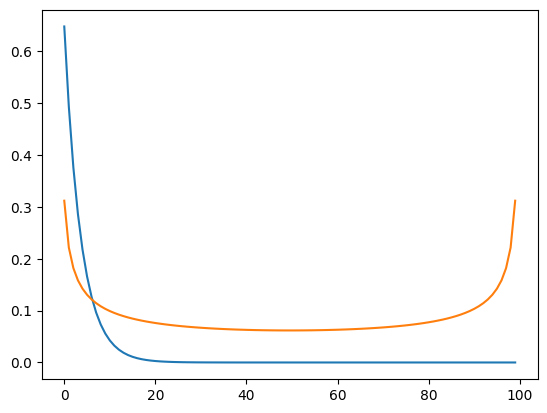

In [7]:
r = 1
d = 100

tmsv = [np.cosh(r)**(-1) * np.tanh(r)**n for n in range(d)]
plt.plot(tmsv)

normalization = 0
for j in range(d):
    normalization += ((j+1)*(d-j))**(-2/N)
approx = [1/(sqrt(normalization) * ((k+1)*(d-k))**(1/N)) for k in range(d)]

plt.plot(approx)

First, we perform the same experiment using a simple TMSV state (everything else remains the same) to see how this inequality reacts to thermal distributions (We can see that the optimal distribution has peaks at the first and last eigenvectors, which is clearly not the case in the TMSV state). 


In [42]:
trunc = 2

TMSV_op = create_TMSV_OP_Dense(trunc+1, mean_photon_num=1, phi = 0, theta = np.pi)
psi = TMSV_op @ np.kron(qt.basis(trunc+1,0).full(), qt.basis(trunc+1,0).full())

# psi[0] = 1/sqrt(2)
# psi[-1] = -1/sqrt(2)
print(psi)

np.trace(psi @ psi.T.conj() @ Bell_operator(trunc+1, trunc+1))

[[0.72211358+2.22301061e-17j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.4119084 +4.62392071e-17j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j]
 [0.55577284+2.36023304e-17j]]


np.complex128(0.6392040749411149+0j)

We see that the TMSV state demonstrates violation for the TMSV state. The violation troughs at bosonic truncation 2 (maximal violation) (Here, the truncation also indicates the number of measurement settings and the number of outcomes per setting) and then increases on both ends. 

Now, we try to run the same experiment with photons encoded in the polarization basis. 

In [45]:
trunc = 5

TMSV_op = create_TMSV_OP_Dense(trunc+1, 1, phi = 0, theta = np.pi)
psi = TMSV_op @ np.kron(qt.basis(trunc+1,0).full(), qt.basis(trunc+1,0).full())

polarization_bell = np.kron(psi, psi)

polarization_bell

array([[0.49984716+3.82539383e-17j],
       [0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j],
       ...,
       [0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j],
       [0.03752745+9.12494026e-18j]], shape=(1296, 1))

The first experiment we do is to vary the depolarization rate and calculate the CHSH value. We first do it for the case of a perfect bell pair. We can use both the single qubit or 2 qubit depolarization channels, which produce different CHSH curves. 

CHSH minima at depolarization rate: 0.7368421052631579
Max. CHSH value: 2.8284271247461916


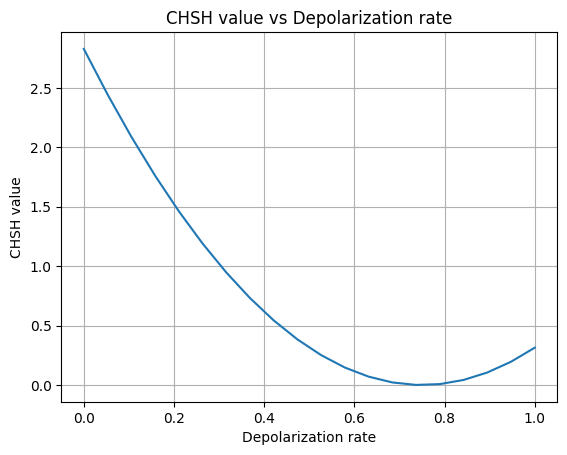

In [4]:
mean_photon_num = 0.25
efficiency = 1
error_tolerance = 1e-10
loss_rate = 0
depolarization_rate_list = np.linspace(0, 1, 20)

# vacuum = create_vacuum_state(num_modes=8, N=N)
# _, psi = light_source(vacuum, N, mean_photon_num, 8, error_tolerance, compress=True, contract=True)
psi = sp.csr_array(create_perfect_bell_state(N, error_tolerance).to_dense())

dm = psi @ psi.conj().T

CHSH_values = []
for depolarization_rate in depolarization_rate_list:

    direct_dm_depol = 0
    
    ############ Using two qubit depolarizing channel
    # depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_rate, N = N)
    # for i in depolarizing_kraus_ops:
    #     direct_dm_depol += i @ dm @ i.conj().T

    ############ Using single qubit depolarizing channel on each qubit
    depolarizing_kraus_ops = depolarizing_operators(depolarization_rate, N)
    for i in depolarizing_kraus_ops:
        for j in depolarizing_kraus_ops:
            depol_op = sp.kron(i, j)
            direct_dm_depol += depol_op @ dm @ depol_op.conj().T

    direct_dm = 0
    loss_kraus_ops = single_mode_bosonic_noise_channels(loss_rate, N)
    for i in loss_kraus_ops:
        for j in loss_kraus_ops:
            for k in loss_kraus_ops:
                for l in loss_kraus_ops:
                    kraus_op = sp.kron(i, sp.kron(j, sp.kron(k,l)))
                    direct_dm += kraus_op @ direct_dm_depol @ kraus_op.conj().T

    CHSH_values.append(calc_CHSH_value(direct_dm, efficiency, N))

index = np.where(CHSH_values == min(CHSH_values))[0][0]

print("CHSH minima at depolarization rate:", depolarization_rate_list[index])
print("Max. CHSH value:", max(CHSH_values))
plt.plot(depolarization_rate_list, CHSH_values)
plt.title("CHSH value vs Depolarization rate")
plt.xlabel("Depolarization rate")
plt.ylabel("CHSH value")
plt.grid()